# CIFAR-10 Classification using pytorch
The notebook is devided into two part:
* Section A where the model is trained with a simple CNN to achieve **75%+ accuracy**
* Section B where the model is trained using ResNet9 and various other techniques like data augmentation, batch normalization, channel normalization, etc to achieve **93%+ accuracy**

# Using a simple CNN model
Bulding a simple CNN to achieve 75% + accuracy

In [1]:
# importing libraries
import os

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
l=60
q=1
i=-1
p=2
z=10
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

# simply define a silu function
# Import basic libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import OrderedDict

# Import PyTorch
import torch # import main library
from torch.autograd import Variable
import torch.nn as nn # import modules
from torch.autograd import Function # import Function to create custom activations
from torch.nn.parameter import Parameter # import Parameter to create custom activations with learnable parameters
from torch import optim # import optimizers for demonstrations
import torch.nn.functional as F # import torch functions
from torchvision import datasets, transforms # import transformations to use for demo

def dynamic(input):
    '''
    Applies the Sigmoid Linear Unit (SiLU) function element-wise:
        SiLU(x) = x * sigmoid(x)
    '''
    #b = input.detach().numpy()
    x=input
    x[x<0]=0
    #x=x+(l/q*(x+i)**p+z)-(l/q*(x-i)**p+z)
    #x=x+60/(torch.abs(x-1)+10)+60/(torch.abs(x+1)+10)
    x=x*2

    return x
    #return  1/(torch.exp(-1*input,out=None)+1)# use torch.sigmoid to make sure that we created the most efficient implemetation based on builtin PyTorch functions

# create a class wrapper from PyTorch nn.Module, so
# the function now can be easily used in models
class Dynamic(nn.Module):
    '''
    Applies the Sigmoid Linear Unit (SiLU) function element-wise:
        SiLU(x) = x * sigmoid(x)
    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input
    References:
        -  Related paper:
        https://arxiv.org/pdf/1606.08415.pdf
    Examples:
        >>> m = dynamic()
        >>> input = torch.randn(2)
        >>> output = m(input)
    '''
    def __init__(self):
        '''
        Init method.
        '''
        super().__init__() # init the base class

    def forward(self, input):
        '''
        Forward pass of the function.
        '''
        return dynamic(input) # simply apply already implemented SiLU

activation_function = Dynamic()

C:\Users\E\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\E\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


We'll download the images in PNG format from [this page](https://course.fast.ai/datasets), using some helper functions from the `torchvision` and `tarfile` packages.

In [2]:
#download dataset
dataset_url = 'https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz'
download_url(dataset_url, '.')

100.0%


In [3]:
# Extract from .tgz archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
  tar.extractall(path = './data')

dataset is extracted to `data/cifar10`. It contains two folders - `train` and `test` containing 50,000 and 10,000 images resp. Each of them contains 10 folders, one for each class of images.

In [4]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/train')
print(classes)
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
# Loading the datset
dataset = ImageFolder(data_dir + '/train', transform = ToTensor())


['test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
img, label = dataset[0]
print(img.shape, label)

img

torch.Size([3, 32, 32]) 0


tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
         [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
         [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
         ...,
         [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
         [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
         [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],

        [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
         [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
         [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
         ...,
         [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
         [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
         [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],

        [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
         [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
         [0.8118, 0.8157, 0.8235,  ..., 0.8235, 0.8157, 0.

In [6]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [7]:
# Viewing an image

def show_img(img, label):
  print('Label: ', dataset.classes[label], '(' + str(label) + ')')
  plt.imshow(img.permute(1, 2, 0)) # permute changes the position of dimentions

Label:  airplane (0)


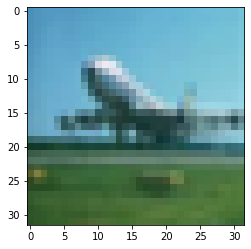

In [8]:
show_img(*dataset[100])

### Training and val datasets

In [9]:
random_seed = 10
torch.manual_seed(random_seed)

In [10]:
val_size = 5000
train_size = len(dataset) - val_size

#splitting the ds
train_ds, val_ds = random_split(dataset, [train_size, val_size])

print(len(train_ds), len(val_ds))

45000 5000


In [11]:
from torch.utils.data.dataloader import DataLoader

batch_size = 128 #hyper parameter

In [12]:
#Loading Data
train_running_size=128
val_running_Size=256
train_ds, empty=random_split(train_ds, [train_running_size, len(train_ds)-train_running_size])
val_ds, empty=random_split(val_ds,[val_running_Size,len(val_ds)-val_running_Size])
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 2, pin_memory = True)

In [13]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize = (12, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow = 16).permute(1,2,0))
    break

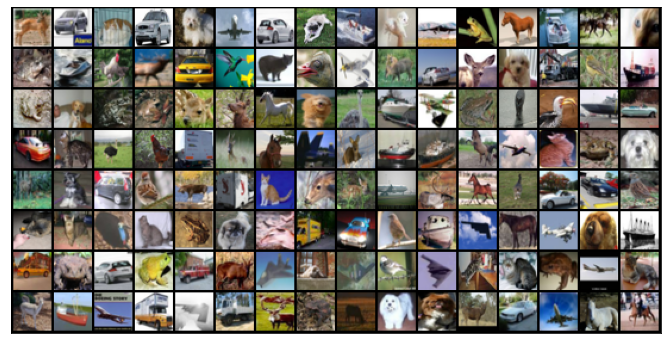

In [14]:
show_batch(train_dl)

### Model
We'll define a CNN (Convolutional Neural Networ)

In [15]:
# importing libraries
import torch.nn as nn
import torch.nn.functional as F

Extending nn.Module

In [16]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Building the architecture of our CNN model

In [17]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            activation_function,
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            activation_function,
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            activation_function,
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            activation_function,
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            activation_function,
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            activation_function,
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            activation_function,
            nn.Linear(1024, 512),
            activation_function,
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [18]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Dynamic()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Dynamic()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): Dynamic()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): Dynamic()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): Dynamic()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): Dynamic()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): Dynamic()
   

In [19]:
for images, labels in train_dl:
  print('images.shape: ', images.shape)
  out = model(images)
  print('out.shape: ', out.shape)
  print('out[0:]: ', out[0])
  break

images.shape:  torch.Size([128, 3, 32, 32])
out.shape:  torch.Size([128, 10])
out[0:]:  tensor([ 0.0163, -0.0581,  0.0294,  0.0303, -0.0527,  0.1837,  0.0272, -0.1032,
         0.0452,  0.0014], grad_fn=<SelectBackward0>)


### GPU

In [20]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [21]:
device = get_default_device()
device

device(type='cuda')

In [22]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

### Training the Model

Defining two models - evaluate and fit

In [23]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [24]:
evaluate(model, val_dl)

{'val_loss': 2.2981903553009033, 'val_acc': 0.109375}

As expected the accuracy is cloase to 10 %

In [25]:
# Hyperparameters
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [26]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 2.3056, val_loss: 5.0284, val_acc: 0.0898
Epoch [1], train_loss: 4.1809, val_loss: 2.3013, val_acc: 0.0898
Epoch [2], train_loss: 2.3075, val_loss: 2.3005, val_acc: 0.0898
Epoch [3], train_loss: 2.2957, val_loss: 2.3016, val_acc: 0.1211
Epoch [4], train_loss: 2.2837, val_loss: 2.3266, val_acc: 0.0898
Epoch [5], train_loss: 2.2676, val_loss: 2.3553, val_acc: 0.1289
Epoch [6], train_loss: 2.2603, val_loss: 2.3136, val_acc: 0.1523
Epoch [7], train_loss: 2.2480, val_loss: 2.3494, val_acc: 0.0977
Epoch [8], train_loss: 2.2439, val_loss: 2.3107, val_acc: 0.0898
Epoch [9], train_loss: 2.2639, val_loss: 2.3075, val_acc: 0.0898


In [27]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs. No. of epochs')

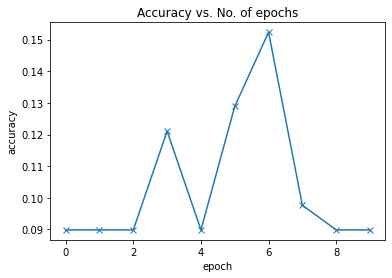

In [28]:
plot_accuracies(history)

In [29]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs No. of epochs')

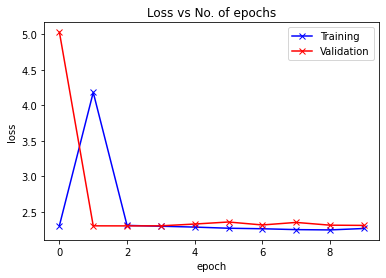

In [30]:
plot_losses(history)

There seems to be some overfitting, which we shall try to minimize in the next section

### Testing

In [31]:
test_dataset = ImageFolder(data_dir + '/test', transform = ToTensor())

In [32]:
def predict_image(imag, model):
  #convert to a batch of 1
  xb = to_device(img.unsqueeze(0), device)

  #get preds from model
  yb = model(xb)

  #pick index with highest probability
  _, preds = torch.max(yb, dim = 1)

  #Retrive the class label
  return dataset.classes[preds[0].item()]

Label:  airplane , Predicted:  deer


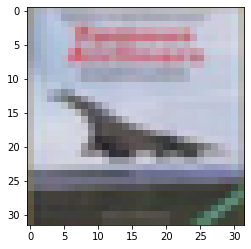

In [33]:
img, label = test_dataset[0]
plt.imshow(img.permute(1,2,0))
print('Label: ', dataset.classes[label], ', Predicted: ', predict_image(img, model))


In [34]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 2.3194923400878906, 'val_acc': 0.09765625}

### Saving the model

In [35]:
torch.save(model.state_dict(), 'cifar10-cnn.pth')

#---------- To load the model ----------

# model2 = to_device(Cifar10CnnModel(), device)
# model2.load_state_dict(torch.load('cifar10-cnn.pth'))

<hr><hr>

# Section 2: Using Resnet9 and various other techniques 
Target is to achieve 90% + accuracy

In [36]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
project_name='05b-cifar10-resnet'

### Loading and Processing Dataset

In [38]:
from torchvision.datasets.utils import download_url

# Download the dataset
dataset_url = 'https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz'
download_url(dataset_url, '.')

#Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
  tar.extractall(path='./data')
    
# Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

Using downloaded and verified file: .\cifar10.tgz
['test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Our target is to achieve maximum accuracy. Therefore we will do following important changes:
1. Using test dataset as validation: to have more training data (although is it a bad practice)
2. Channel-wize data normalization: normalize the image tensor by subtracting the mean an divind by std deviation. It prevents the values from any one channel from disproportionately affecting the losses and gradients while training simple by having a higher or wider range.
<img src="https://i.imgur.com/LYxXBVg.png" alt="normalization" width="30%"/>

3. Randomized data augmentation: We will apply randomly chosen transformation while loading images from the training dataset. It enables the model to see different images in each epoch of training.
<img src="https://imgaug.readthedocs.io/en/latest/_images/cropandpad_percent.jpg" alt="data-augmentation" width = 60% />


### Data Transformation
Normalization and Data Augmentation

In [39]:
#Data transforms (normalization and data augmentation)

stats = ((0.4914, 0.4822, 0.4465),
         (0.2023, 0.1994, 0.2010))

train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*stats, inplace=True)])

valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])


In [40]:
batch_size = 500 #hyperparameter

In [41]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

In [42]:
# Pytorch Data Loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=2, pin_memory=True)

In [43]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

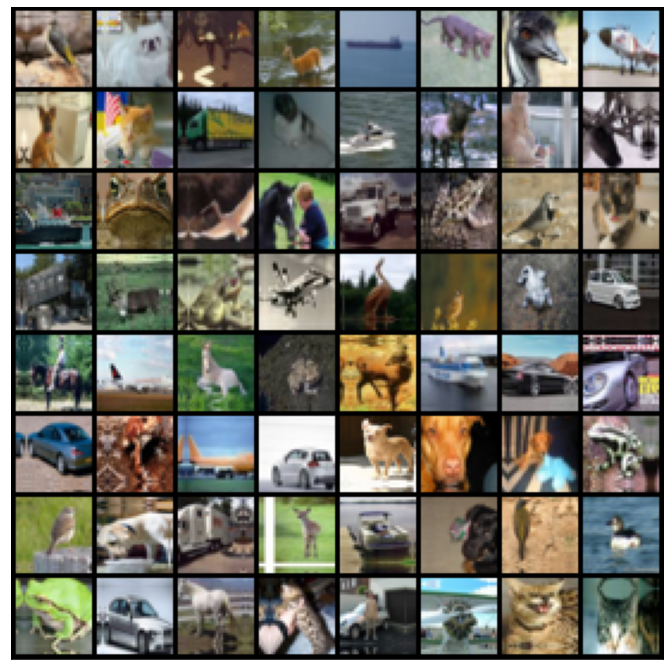

In [44]:
show_batch(train_dl)

### Uploading on GPU

In [45]:
### Using a GPU
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [46]:
device = get_default_device()
device


device(type='cuda')

In [47]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

### Model with Residual Block and batch normalization
One of the key changes to our CNN model this time is the addition of the resudial block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers
<br><br>
<img src="https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png"/>

Defining a Simple Residual Block

In [48]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = activation_function
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = activation_function
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [49]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break
    
del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([500, 3, 32, 32])


We shall use ResNet architecture.
<img src='https://raw.githubusercontent.com/lambdal/cifar10-fast/master/net.svg' />

Extending nn.Module class

In [50]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

Building our architecture:

In [51]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              activation_function]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [52]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dynamic()
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dynamic()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dynamic()
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dynamic()
    )
  )
  (conv3): Sequential(

### Training the Model
The improvements in fit functions are:
1. Learning rate scheduling: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. We will use one cycle policy [1cycle policy](https://sgugger.github.io/the-1cycle-policy.html).
2. Weight Decay: A regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.
3. Gradient clipping: Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values


In [53]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [54]:
# Evaluating the model before training
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.918414354324341, 'val_acc': 0.12039999663829803}]

In [55]:
epochs = 16
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [56]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00138, train_loss: 1.9339, val_loss: 1.3116, val_acc: 0.5350
Epoch [1], last_lr: 0.00394, train_loss: 1.3344, val_loss: 1.5912, val_acc: 0.5371
Epoch [2], last_lr: 0.00703, train_loss: 1.0924, val_loss: 1.2933, val_acc: 0.5917
Epoch [3], last_lr: 0.00935, train_loss: 0.9379, val_loss: 1.5035, val_acc: 0.6176
Epoch [4], last_lr: 0.00999, train_loss: 0.7857, val_loss: 0.8004, val_acc: 0.7181
Epoch [5], last_lr: 0.00972, train_loss: 0.6072, val_loss: 0.6999, val_acc: 0.7576
Epoch [6], last_lr: 0.00908, train_loss: 0.5007, val_loss: 0.5122, val_acc: 0.8297
Epoch [7], last_lr: 0.00812, train_loss: 0.4545, val_loss: 0.8677, val_acc: 0.7335
Epoch [8], last_lr: 0.00691, train_loss: 0.3932, val_loss: 0.5832, val_acc: 0.8110
Epoch [9], last_lr: 0.00556, train_loss: 0.3391, val_loss: 0.4376, val_acc: 0.8566
Epoch [10], last_lr: 0.00416, train_loss: 0.2993, val_loss: 0.3541, val_acc: 0.8777
Epoch [11], last_lr: 0.00283, train_loss: 0.2424, val_loss: 0.3317, val_acc: 0.8890
Ep

In [57]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

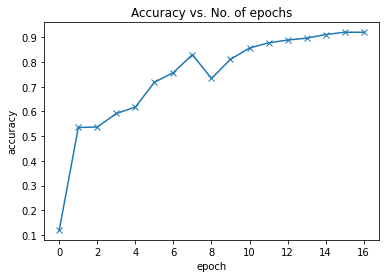

In [58]:
plot_accuracies(history)

In [59]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

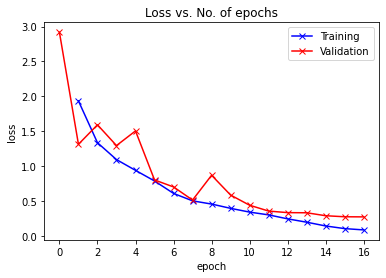

In [60]:
plot_losses(history)

In [61]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

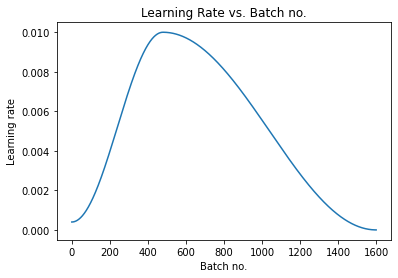

In [62]:
plot_lrs(history)

## Testing with individual images


In [63]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: cat , Predicted: cat


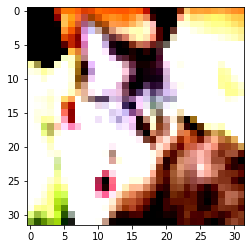

In [64]:
img, label = valid_ds[3001]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model))

In [65]:
torch.save(model.state_dict(), 'cifar10-resnet9-2.pth')

In [66]:
# ######## TO FREE GPU Memory #############


# !pip install GPUtil
# import torch
# from GPUtil import showUtilization as gpu_usage
# from numba import cuda

# def free_gpu_cache():
#     print("Initial GPU Usage")
#     gpu_usage()
#     torch.cuda.empty_cache()
#     cuda.select_device(0)
#     cuda.close()
#     cuda.select_device(0)
#     print("GPU Usage after emptying the cache")
#     gpu_usage()

# free_gpu_cache()                           

## Summary and References
We trained state-of-the-art deep learning models from scratch.

Here's a summary of the different techniques used in this project to improve our model performance and reduce the training time:


* **Data normalization**: We normalized the image tensors by subtracting the mean and dividing by the standard deviation of pixels across each channel. Normalizing the data prevents the pixel values from any one channel from disproportionately affecting the losses and gradients. [Learn more](https://medium.com/@ml_kid/what-is-transform-and-transform-normalize-lesson-4-neural-networks-in-pytorch-ca97842336bd)

* **Data augmentation**: We applied random transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability. [Learn more](https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/)

* **Residual connections**: One of the key changes to our CNN model was the addition of the resudial block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers. We used the ResNet9 architecture [Learn more](https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec).

* **Batch normalization**: After each convolutional layer, we added a batch normalization layer, which normalizes the outputs of the previous layer. This is somewhat similar to data normalization, except it's applied to the outputs of a layer, and the mean and standard deviation are learned parameters. [Learn more](https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd)

* **Learning rate scheduling**: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are [many strategies](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) for varying the learning rate during training, and we used the "One Cycle Learning Rate Policy". [Learn more](https://sgugger.github.io/the-1cycle-policy.html)

* **Weight Decay**: We added weight decay to the optimizer, yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function. [Learn more](https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab)

* **Gradient clipping**: We also added gradient clippint, which helps limit the values of gradients to a small range to prevent undesirable changes in model parameters due to large gradient values during training.  [Learn more.](https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48#63e0)

* **Adam optimizer**: Instead of SGD (stochastic gradient descent), we used the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training. There are many other optimizers to choose froma and experiment with. [Learn more.](https://ruder.io/optimizing-gradient-descent/index.html)

<hr><hr>

<span> -------------------- THE END -------------------- </span>
